<a href="https://colab.research.google.com/github/sverdoot/optimizer-SUG-torch/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Optimization project")
os.getcwd()

file_path = "./CIFAR10"
#directory = os.path.dirname(file_path)

try:
    os.stat(file_path)
except:
    os.mkdir(file_path)       

In [0]:
import sug
from sug import SUG

In [0]:
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import time

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

## Data

In [0]:
batch_size = 4

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

valid_dataset = torchvision.datasets.CIFAR10(root='/data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


0it [00:00, ?it/s]

170500096it [00:06, 28214235.20it/s]                               


Files already downloaded and verified


In [0]:
valid_size=0.15
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, 
               batch_size=batch_size, sampler=train_sampler,
               num_workers=2)

validloader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=batch_size, sampler=valid_sampler,
               num_workers=2)

In [0]:
batchs_per_epoch = len(trainloader) / batch_size

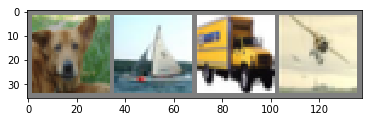

  dog	 ship	truck	plane


In [14]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(validloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Model

### simple CNN

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train

In [0]:
import math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward()
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [0]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, validloader=None, eps=1e-5, print_every=1):
    tr_loss, val_loss, lips, times, grad, acc = ([] for i in range(6))
    start_time = time.time()
    model.to(device=device)
    for ep in range(n_epochs):
        model.train()
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            tr_loss.append(model_step(model, optimizer, criterion, inputs, labels))
            if optimizer.__class__.__name__ == 'SUG':
                lips.append(optimizer.get_lipsitz_const())
                grad.append(optimizer.get_sq_grad)
        times.append(time_since(start_time))
        if ep % print_every == 0:
            print("Epoch {}, training loss {}, time passed {}".format(ep, sum(tr_loss[-i:]) / i, time_since(start_time)))

        if validloader is None:
            continue
        model.zero_grad()
        model.eval()
        j = 0
        for j, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            val_loss.append(model_step(model, optimizer, criterion, inputs, labels))
        if ep % print_every == 0:
            print("Validation loss {}".format(sum(val_loss[-j:]) / j))
        
    return tr_loss, times, val_loss, lips, grad

In [0]:
def concat_states(state1, state2):
    states = {
            'epoch': state1['epoch'] + state2['epoch'],
            'state_dict': state2['state_dict'],
            'optimizer': state2['optimizer'],
            'tr_loss' : state1['tr_loss'] + state2['tr_loss'],
            'val_loss' : state1['val_loss'] + state2['val_loss'],
            'lips' : state1['lips'] + state2['lips'],
            'grad' : state1['grad'] + state2['grad'],
            'times' : state1['times'] + list(map(lambda x: x + state1['times'][-1],state2['times']))
             }
    return states

In [0]:
print_every = 4
n_epochs = 20
tr_loss = {}
tr_loss['sgd'] = {}
val_loss = {}
val_loss['sgd'] = {}
lrs = [0.01, 0.005]
criterion = nn.CrossEntropyLoss(reduction="mean")

In [0]:
for lr in lrs:
  model = CNN()
  #state = torch.load('./CIFAR10/CNN_' + str(lr))
  #model.load_state_dict(state['state_dict'])
  #model.load_state_dict(state)
  print("SGD  lr={}, momentum=0. :".format(lr))
  #model = CNN()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
  #state = concat_states(state, states)
  torch.save(states, './CIFAR10/CNN_' + str(lr))
  #torch.save(states, './CIFAR10/CNN_' + str(lr))

SGD  lr=0.01, momentum=0. :
Epoch 0, training loss 0.6779449275605022, time passed 0m 37s
Validation loss 0.6575411162483272
Epoch 4, training loss 0.6189495169961579, time passed 3m 33s
Validation loss 0.9533135285690475
Epoch 8, training loss 0.6028648142686046, time passed 6m 27s
Validation loss 1.1153351957477398
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 0.5732823346393654, time passed 0m 42s
Validation loss 0.5828254481612555
Epoch 4, training loss 0.48028830949116097, time passed 3m 39s
Validation loss 0.8323193062554047
Epoch 8, training loss 0.4310017076898815, time passed 6m 36s
Validation loss 0.9820830017614517


In [0]:
l_0 = 2
model = CNN()
#n_epochs = 4
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.)
tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
        }
torch.save(states, './CIFAR10/CNN_sug')

Epoch 0, training loss 0.4989453318882285, time passed 1m 29s
Validation loss 0.49379758652907935


In [0]:
model = CNN()
#n_epochs = 4
optimizer = optim.Adam(model.parameters(), lr=0.005)
tr_loss['adam'], times, val_loss['adam'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['adam'],
            'val_loss' : val_loss['adam'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
        }
torch.save(states, './CIFAR10/CNN_adam')